# Interest Rate Prediction

### Loading and Exploring Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

# Data preprocessing
data = pd.read_csv("FEDFUNDS.csv")

# normalize percentages to [0, 1]
data['FEDFUNDS'] = data['FEDFUNDS'] / 100

# combine into one dataframe
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

2024-11-29 23:07:37.868063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 23:07:37.885266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 23:07:38.166910: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 23:07:38.445489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 23:07:38.643270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

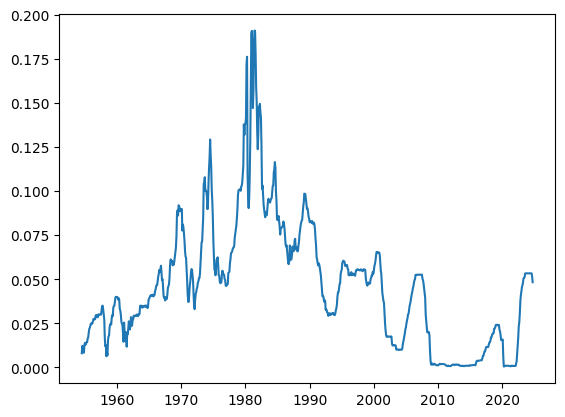

In [3]:
plt.plot(data)
plt.show()

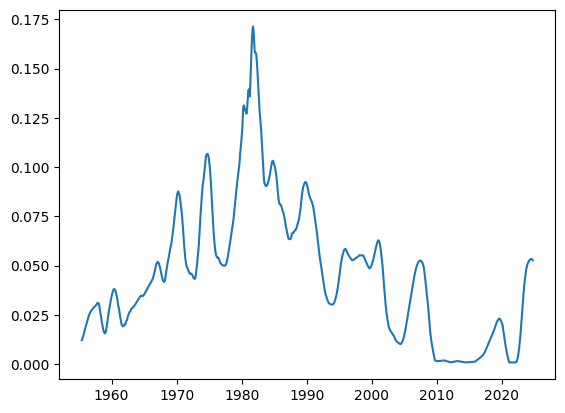

In [ ]:
moving_average = data['FEDFUNDS'].rolling(window=12).mean()
plt.plot(moving_average)
plt.show()

# helps to see the trend without as much noise

### Preparing Data

In [103]:
def create_dataset(data, window=24, average_window=12):
    datanp = np.array(data)
    X, y = [], []
    for i in range(len(datanp) - window):
        # add index and rolling average to X
        X.append([[
            x[0], 
            datanp[max(0, i-average_window//2):min(len(datanp), i+average_window//2)].mean(),
            j
        ] for j, x in enumerate(datanp[i:i+window])])
        y.append(datanp[i+window])
    return np.array(X).astype('float32'), np.array(y).astype('float32')

window_size = 12*12
average_window = 12
X, y = create_dataset(data, window=window_size, average_window=average_window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(560, 144, 3) (560, 1)
(140, 144, 3) (140, 1)


In [104]:
print(X_train)

[[[1.9800000e-02 1.9116666e-02 0.0000000e+00]
  [1.7300000e-02 1.9116666e-02 1.0000000e+00]
  [1.1700000e-02 1.9116666e-02 2.0000000e+00]
  ...
  [6.5800004e-02 1.9116666e-02 1.4100000e+02]
  [7.0900001e-02 1.9116666e-02 1.4200000e+02]
  [7.1199998e-02 1.9116666e-02 1.4300000e+02]]

 [[1.7999999e-02 1.7491667e-02 0.0000000e+00]
  [2.2700001e-02 1.7491667e-02 1.0000000e+00]
  [2.4200000e-02 1.7491667e-02 2.0000000e+00]
  ...
  [7.2099999e-02 1.7491667e-02 1.4100000e+02]
  [6.6200003e-02 1.7491667e-02 1.4200000e+02]
  [6.2899999e-02 1.7491667e-02 1.4300000e+02]]

 [[5.0600000e-02 5.4274999e-02 0.0000000e+00]
  [5.3300001e-02 5.4274999e-02 1.0000000e+00]
  [5.9400000e-02 5.4274999e-02 2.0000000e+00]
  ...
  [1.1640000e-01 5.4274999e-02 1.4100000e+02]
  [1.1300000e-01 5.4274999e-02 1.4200000e+02]
  [9.9900000e-02 5.4274999e-02 1.4300000e+02]]

 ...

 [[4.6100002e-02 4.9933333e-02 0.0000000e+00]
  [4.6799999e-02 4.9933333e-02 1.0000000e+00]
  [4.6900000e-02 4.9933333e-02 2.0000000e+00]
  ..

### Model Architecture

In [117]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 3)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 144, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,881 (230.00 KB)

 Trainable params: 58,881 (230.00 KB)

 Non-trainable params: 0 (0.00 B)

In [128]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.0123 - mae: 0.0123
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0117 - mae: 0.0117
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0125 - mae: 0.0125
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0118 - mae: 0.0118
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0128 - mae: 0.0128
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0123 - mae: 0.0123
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0151 - mae: 0.0151
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.0127 - mae: 0.0127
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0132 - mae: 0.0132
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0137 - mae: 0.0137
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0148 - mae: 0.0148
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0128 - mae: 0.0128
Epoch 13/50
18/18 ━━━━━━━

### Model Validation

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


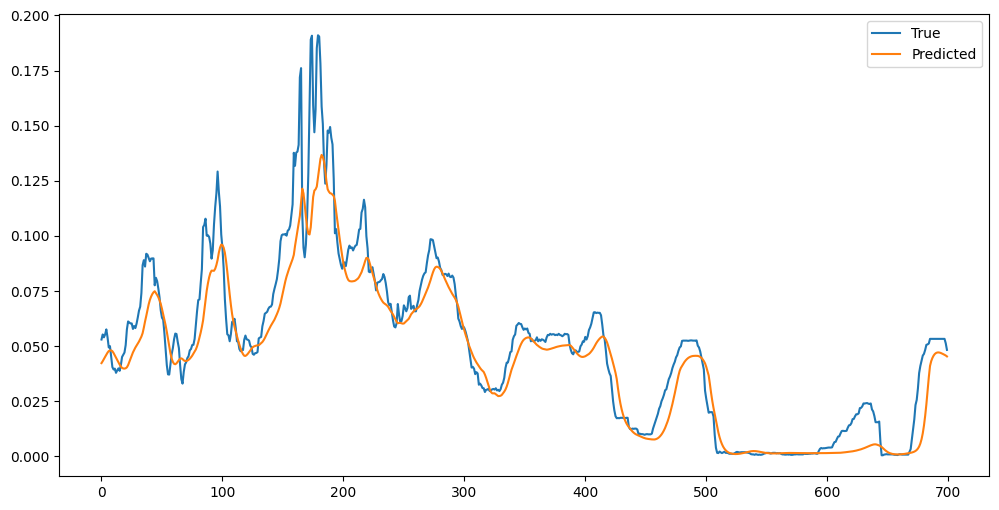

In [130]:
# plotting both the predictions and the test data

y_pred = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(y, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


### Final Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
0.052966665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.051639605313539505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.05020074049631754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.04861721210181713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.0468758170803388
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.044972156484921776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.04324280905226866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.04235740813116232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.04144778226812681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.040561443815628685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.03972903825342655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.03897205243508021


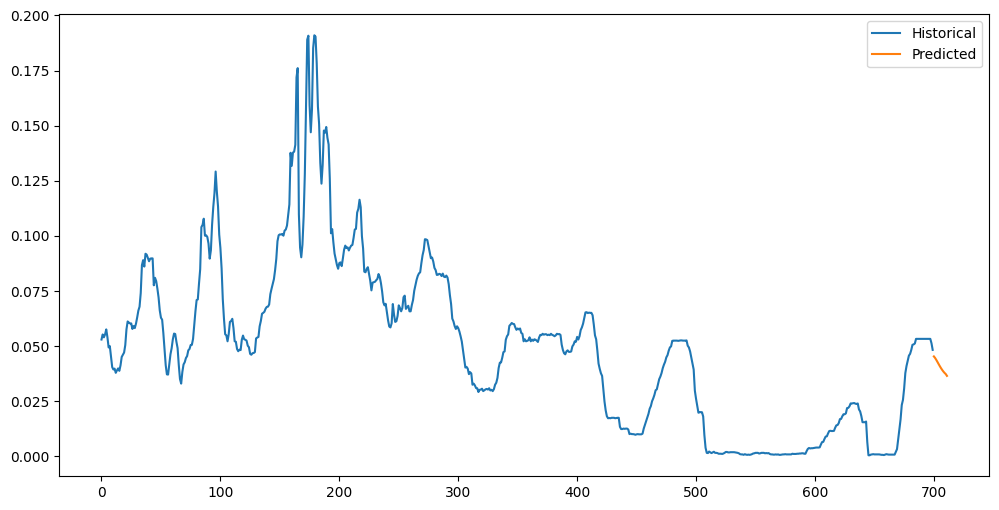

In [137]:
def predict_interest_rates(months=5):
    last_window = X[-1]
    predictions = []
    for i in range(months):
        prediction = model.predict(np.array([last_window]))
        predictions.append(prediction[0])
        
        # recalculate moving average and new index
        moving_average = np.array([x[0] for x in last_window[-average_window//2:]]).mean()
        print(moving_average)
        last_window = np.append(last_window[1:], [[prediction[0][0], moving_average, last_window[-1][2]+1]], axis=0)
    return predictions

predictions = predict_interest_rates(12)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Historical')
plt.plot(range(len(y), len(y) + len(predictions)), predictions, label='Predicted')
plt.legend()
plt.show()

In [138]:
data.tail()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Predicted interest rates:")
year = 2024

for i, prediction in enumerate(predictions):
    month = (i+10)%12
    print(f"{months[month]} {year}: {prediction[0]*100:.2f}%")
    if month == 11:
        year += 1

Predicted interest rates:
Nov 2024: 4.53%
Dec 2024: 4.47%
Jan 2025: 4.38%
Feb 2025: 4.29%
Mar 2025: 4.19%
Apr 2025: 4.09%
May 2025: 4.00%
Jun 2025: 3.92%
Jul 2025: 3.85%
Aug 2025: 3.79%
Sep 2025: 3.73%
Oct 2025: 3.65%
